In [1]:
%matplotlib inline
from astropy import table
from collections import defaultdict
import numpy as np
from pathlib import Path
import betterplotlib as bpl

bpl.set_style()

# Examining $r_{eff}$

I want to compare values for the two runs, then look at differences to pick the better one

In [2]:
data_dir = Path("../data/").resolve()

Get a list of all versions of the catalog creation.

In [3]:
catalogs = defaultdict(dict)
for galaxy in data_dir.iterdir():
    for item in (data_dir / galaxy / "size").iterdir():
        if item.name.startswith("final_catalog") and "multiplestarts" in item.name and "thetascale" not in item.name:
            run_name = item.stem.replace("final_catalog_", "")
            run_name = run_name.replace("_30_pixels_psf_my_stars_15_pixels_2x_oversampled", "")
            run_name = run_name.replace("radialweighting3pix_abs_bgscale1e3_", "")
            run_name = run_name.replace("_multiplestarts", "")
            run_name = run_name.replace("_luminosity_powell", "")
            if run_name == "noaprior_noqprior":
                run_name = "With BG Prior"
            elif run_name == "nopriorsatall":
                run_name = "No BG Prior"
            else:
                raise ValueError

            this_cat = table.Table.read(item, format="ascii.ecsv")
            this_cat["galaxy"] = galaxy.name
            catalogs[galaxy.name][run_name] = this_cat

Then combine them into one master catalog, where each cluster has the effective radius returned by the two methods

In [4]:
for gal in catalogs:
    for style, cat in catalogs[gal].items():
        r_eff = cat["r_eff_pixels_rmax_15pix_best"]
        
        new_col = f"r_eff_{style}"
        cat[new_col] = r_eff
        
        # and delete all other columns
        for col in cat.colnames:
            if col not in ["galaxy", "ID", new_col]:
                del cat[col]

Then combine together into one master catalog

In [5]:
big_cat = None
for gal in catalogs:
    if len(catalogs[gal]) != 2:
        print("skipping", gal)
        continue
    this_gal_table = None
    for cat in catalogs[gal].values():
        # for the first item we just use it
        if this_gal_table is None:
            this_gal_table = cat
        else: # if the table already exists we join the columns to it
            this_gal_table = table.join(this_gal_table, cat, join_type="inner", keys=["ID", "galaxy"])

    # We've combined the tables for the individual galaxy, then stack them together
    if big_cat is None:
        big_cat = this_gal_table
    else:
        big_cat = table.vstack([big_cat, this_gal_table])

skipping ugc4305
skipping ngc7793-e
skipping ugc1249
skipping ugc7408
skipping ngc5194-ngc5195-mosaic
skipping ngc1566


In [6]:
big_cat.colnames

['ID', 'galaxy', 'r_eff_With BG Prior', 'r_eff_No BG Prior']

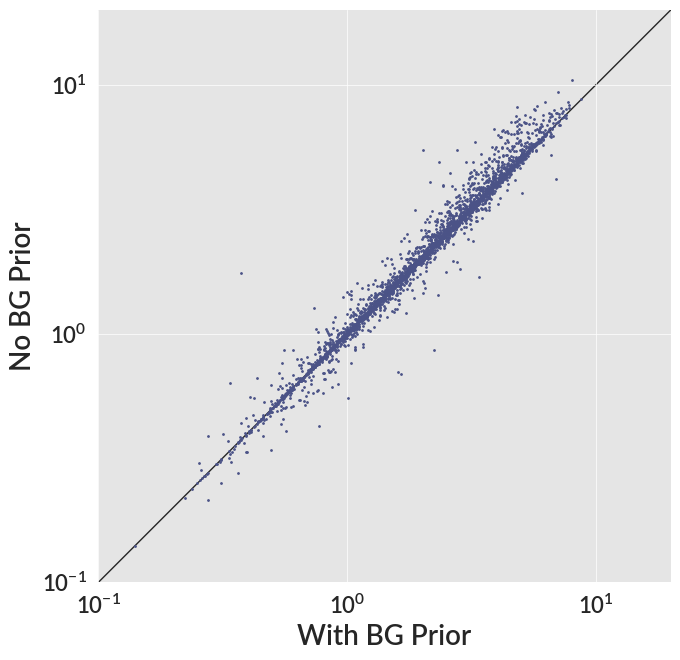

In [7]:
fig, ax = bpl.subplots()
ax.scatter(big_cat["r_eff_With BG Prior"], big_cat["r_eff_No BG Prior"],
           alpha=1, s=1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.make_ax_dark()
ax.plot([0.0001, 100], [0.0001, 100], zorder=0, c=bpl.almost_black, lw=1)
ax.add_labels("With BG Prior", "No BG Prior")
ax.equal_scale()
ax.set_limits(0.1, 20, 0.1, 20)

Looks pretty close, let's examine some of the differences

In [12]:
ratios = big_cat["r_eff_With BG Prior"] / big_cat["r_eff_No BG Prior"]
big_cat["ratio"] = np.maximum(ratios, 1.0 / ratios)

In [19]:
big_cat[np.logical_and(big_cat["ratio"] > 1.3, big_cat["r_eff_With BG Prior"] < 1)]

ID,galaxy,r_eff_With BG Prior,r_eff_No BG Prior,ratio
int64,str9,float64,float64,float64
1941,ngc6503,0.5696120688288565,0.40463358796663873,1.4077231494579237
2421,ngc6503,0.9957289889098296,1.4699095762418144,1.476214504763128
3345,ngc6503,0.9203561476902672,0.6296709439711109,1.461646208233634
506,ngc3738,0.7635789462262744,1.0131552428090354,1.3268506783957386
30,ngc1433,0.2766352276701195,0.38903921666145264,1.4063256510677375
836,ngc1433,0.3629082759529652,0.2746692045734941,1.3212557866342847
398,ngc7793-w,0.5310732576804028,0.6959721290887507,1.3105011766711538
415,ugc5139,0.3735078917829589,1.7511659353136673,4.688430884162548
72,ngc1705,0.6803162180295838,0.5177426086129668,1.3140046940547385
